<a href="https://colab.research.google.com/github/Onyimatics/time_seres_heart_rate_prediction/blob/master/Best_Heart_Rate_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install libraries

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00


Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
# %matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error,mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

Load the dataset

In [ ]:
heart_rate_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1qGL_DhVTU0Nc36Sl-I5VxHqyedJX5_zi')
heart_rate_df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [ ]:
heart_rate_df.shape

(226, 5)

In [ ]:
heart_rate_df.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,226.000000,226.000000,191.000000,191.000000
mean,2315.615044,2219.216814,83.450262,126.335079
std,11351.588825,11370.093548,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,145.000000,46.000000,93.000000,139.000000
75%,156.000000,53.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


I will like to rename the columns for easy access

In [ ]:
heart_rate_df.columns = heart_rate_df.columns.str.strip() # remove unexpected spaces
heart_rate_df = heart_rate_df.rename(columns={"Timestamp (GMT)": "timestamp_gmt", "Lifetouch Heart Rate": "heart_rate",
                        "Lifetouch Respiration Rate": "respiration_rate", "Oximeter SpO2": "oximeter", "Oximeter Pulse": "oximeter_pulse"})
heart_rate_df.head()

,timestamp_gmt,heart_rate,respiration_rate,oximeter,oximeter_pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


Converting Timestamp (GMT) to a datetime format and set as Index

In [ ]:
heart_rate_df['timestamp_gmt']=pd.to_datetime(heart_rate_df['timestamp_gmt'])
heart_rate_df.set_index('timestamp_gmt', inplace=True)
heart_rate_df

,heart_rate,respiration_rate,oximeter,oximeter_pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159,51,NaN,NaN
2015-08-17 18:51:00,151,64,NaN,NaN
2015-08-17 18:52:00,140,64,NaN,NaN


In [ ]:
heart_rate_df.shape

(226, 4)

Visualizing the Time Series plot for the Heart Rates

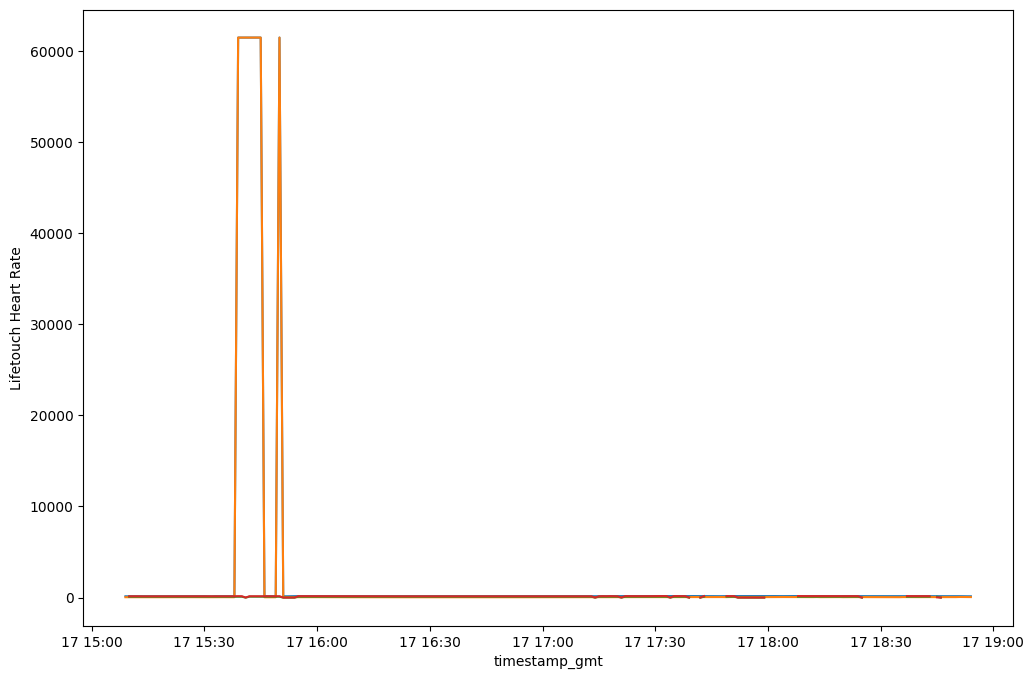

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel("timestamp_gmt")
plt.ylabel("Lifetouch Heart Rate")
plt.plot(heart_rate_df)

From the plot above, there are obviously some outliers

##**DATA WRANGLING**

Check for null values

In [ ]:
heart_rate_df.isnull().sum()

,0
heart_rate,0
respiration_rate,0
oximeter,35
oximeter_pulse,35


In [ ]:
# Forward fill, then backward fill
heart_rate_df["oximeter"] = heart_rate_df["oximeter"].ffill().bfill()
heart_rate_df["oximeter_pulse"] = heart_rate_df["oximeter_pulse"].ffill().bfill()

# Verify if missing values are filled
heart_rate_df.isnull().sum()

,0
heart_rate,0
respiration_rate,0
oximeter,0
oximeter_pulse,0


In [ ]:
heart_rate_df.head(300)

,heart_rate,respiration_rate,oximeter,oximeter_pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139,41,92.0,140.0
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159,51,-1.0,-1.0
2015-08-17 18:51:00,151,64,-1.0,-1.0
2015-08-17 18:52:00,140,64,-1.0,-1.0


In [ ]:
# Detect Outliers Using IQR Method

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = heart_rate_df["heart_rate"].quantile(0.25)
Q3 = heart_rate_df["heart_rate"].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Define outlier bounds (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = heart_rate_df[(heart_rate_df["heart_rate"] < lower_bound) | (heart_rate_df["heart_rate"] > upper_bound)]

# Display outliers
outliers, outliers.shape

(                     heart_rate  respiration_rate  oximeter  oximeter_pulse
 timestamp_gmt                                                              
 2015-08-17 15:39:00       61441             61441      94.0           152.0
 2015-08-17 15:40:00       61442             61442      92.0           146.0
 2015-08-17 15:41:00       61441             61441      -1.0            -1.0
 2015-08-17 15:42:00       61441             61441      98.0           143.0
 2015-08-17 15:43:00       61441             61441      97.0           142.0
 2015-08-17 15:44:00       61441             61441      96.0           140.0
 2015-08-17 15:45:00       61442             61442      96.0           144.0
 2015-08-17 15:50:00       61442             61442      94.0           148.0,
 (8, 4))

In [ ]:
def handle_outliers(df, column):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"Outliers in {column}:")
    print(outliers)
    print(f"Number of outliers: {outliers.shape[0]}")

    # Replace outliers with NaN
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan

    # Interpolate missing values
    df[column].interpolate(method='time', inplace=True)

    # Verify if outliers are removed
    outliers_after_cleaning = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"\nOutliers after cleaning in {column}:")
    print(outliers_after_cleaning)
    print(f"Number of remaining outliers: {outliers_after_cleaning.shape[0]}")

# Handle outliers for heart_rate
handle_outliers(heart_rate_df, "heart_rate")

# Handle outliers for respiration_rate
handle_outliers(heart_rate_df, "respiration_rate")

# Display the first few rows of the cleaned dataframe
print("\nCleaned dataframe:")
print(heart_rate_df.head())

# Check for any remaining NaN values
print("\nRemaining NaN values:")
print(heart_rate_df.isna().sum())


Outliers in heart_rate:
                     heart_rate  respiration_rate  oximeter  oximeter_pulse
timestamp_gmt                                                              
2015-08-17 15:39:00       61441             61441      94.0           152.0
2015-08-17 15:40:00       61442             61442      92.0           146.0
2015-08-17 15:41:00       61441             61441      -1.0            -1.0
2015-08-17 15:42:00       61441             61441      98.0           143.0
2015-08-17 15:43:00       61441             61441      97.0           142.0
2015-08-17 15:44:00       61441             61441      96.0           140.0
2015-08-17 15:45:00       61442             61442      96.0           144.0
2015-08-17 15:50:00       61442             61442      94.0           148.0
Number of outliers: 8

Outliers after cleaning in heart_rate:
Empty DataFrame
Columns: [heart_rate, respiration_rate, oximeter, oximeter_pulse]
Index: []
Number of remaining outliers: 0
Outliers in respiration_rate:


In [ ]:
# # Detect Outliers Using IQR Method

# # Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Q1 = heart_rate_df["heart_rate"].quantile(0.25)
# Q3 = heart_rate_df["heart_rate"].quantile(0.75)
# IQR = Q3 - Q1  # Interquartile range

# # Define outlier bounds (1.5 * IQR rule)
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Identify outliers
# outliers = heart_rate_df[(heart_rate_df["heart_rate"] < lower_bound) | (heart_rate_df["heart_rate"] > upper_bound)]

# # Display outliers
# outliers, outliers.shape


In [ ]:
heart_rate_df.isnull().sum()

,0
heart_rate,0
respiration_rate,0
oximeter,0
oximeter_pulse,0


In [ ]:
# # Detect Outliers Using IQR Method

# # Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Q1 = heart_rate_df["respiration_rate"].quantile(0.25)
# Q3 = heart_rate_df["respiration_rate"].quantile(0.75)
# IQR = Q3 - Q1  # Interquartile range

# # Define outlier bounds (1.5 * IQR rule)
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Identify outliers
# outliers = heart_rate_df[(heart_rate_df["respiration_rate"] < lower_bound) | (heart_rate_df["respiration_rate"] > upper_bound)]

# # Display outliers
# outliers, outliers.shape

In [ ]:
heart_rate_df.shape

(226, 4)

In [ ]:
# # Replace extreme outliers with NaN
# heart_rate_df.loc[(heart_rate_df["heart_rate"] > upper_bound), "heart_rate"] = np.nan

# # Drop rows that now contain NaN values in the 'heart_rate' column
# heart_rate_df.dropna(subset=["heart_rate"], inplace=True)

# # Verify if any rows with extreme outliers remain
# outliers_after_cleaning = heart_rate_df[heart_rate_df["heart_rate"] > upper_bound]
# print(outliers_after_cleaning)


In [ ]:
# # Replace extreme outliers with NaN
# heart_rate_df.loc[(heart_rate_df["heart_rate"] > upper_bound), "heart_rate"] = np.nan

# # Interpolate missing values using time-based interpolation
# heart_rate_df.interpolate(method='time', inplace=True)

# # Verify if outliers are removed (should be empty if all were handled)
# outliers_after_cleaning = heart_rate_df[(heart_rate_df["heart_rate"] > upper_bound)]
# print(outliers_after_cleaning)

Empty DataFrame
Columns: [heart_rate, respiration_rate, oximeter, oximeter_pulse]
Index: []


In [ ]:
heart_rate_df.isnull().sum()

,0
heart_rate,0
respiration_rate,0
oximeter,35
oximeter_pulse,35


In [ ]:
heart_rate_df.head(300)

,heart_rate,respiration_rate,oximeter,oximeter_pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0
2015-08-17 15:10:00,144.0,40.0,92.0,140.0
2015-08-17 15:11:00,140.0,42.0,89.0,144.0
2015-08-17 15:12:00,138.0,45.0,93.0,141.0
2015-08-17 15:13:00,133.0,42.0,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159.0,51.0,-1.0,-1.0
2015-08-17 18:51:00,151.0,64.0,-1.0,-1.0
2015-08-17 18:52:00,140.0,64.0,-1.0,-1.0


In [ ]:
heart_rate_df.shape

(226, 4)

In [ ]:
heart_rate_df.head(300)

,heart_rate,respiration_rate,oximeter,oximeter_pulse
timestamp_gmt,,,,
2015-08-17 15:09:00,139.0,41.0,92.0,140.0
2015-08-17 15:10:00,144.0,40.0,92.0,140.0
2015-08-17 15:11:00,140.0,42.0,89.0,144.0
2015-08-17 15:12:00,138.0,45.0,93.0,141.0
2015-08-17 15:13:00,133.0,42.0,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159.0,51.0,-1.0,-1.0
2015-08-17 18:51:00,151.0,64.0,-1.0,-1.0
2015-08-17 18:52:00,140.0,64.0,-1.0,-1.0


In [ ]:
heart_rate_df.describe()

,heart_rate,respiration_rate,oximeter,oximeter_pulse
count,226.000000,226.000000,226.000000,226.000000
mean,145.353982,2219.216814,73.367257,111.495575
std,11.457578,11370.093548,39.245581,60.339134
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,133.000000
50%,142.000000,46.000000,93.000000,137.000000
75%,155.000000,53.000000,95.000000,148.000000
max,172.000000,61442.000000,98.000000,166.000000


In [ ]:
heart_rate_df['time_diff'] = heart_rate_df.index.to_series().diff().dropna()  # Calculate time differences
print(heart_rate_df['time_diff'].value_counts())  # Check unique time gaps

time_diff
0 days 00:01:00    225
Name: count, dtype: int64


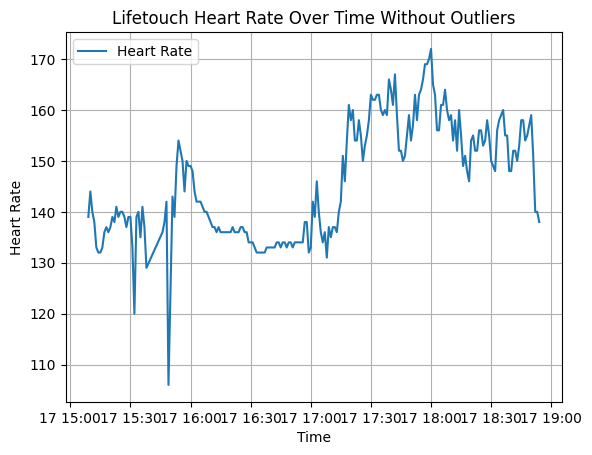

In [ ]:
# plt.figure(figsize=(12, 5))
plt.plot(heart_rate_df["heart_rate"], linestyle="-", label="Heart Rate")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Lifetouch Heart Rate Over Time Without Outliers")
plt.legend()
plt.grid()
plt.show()

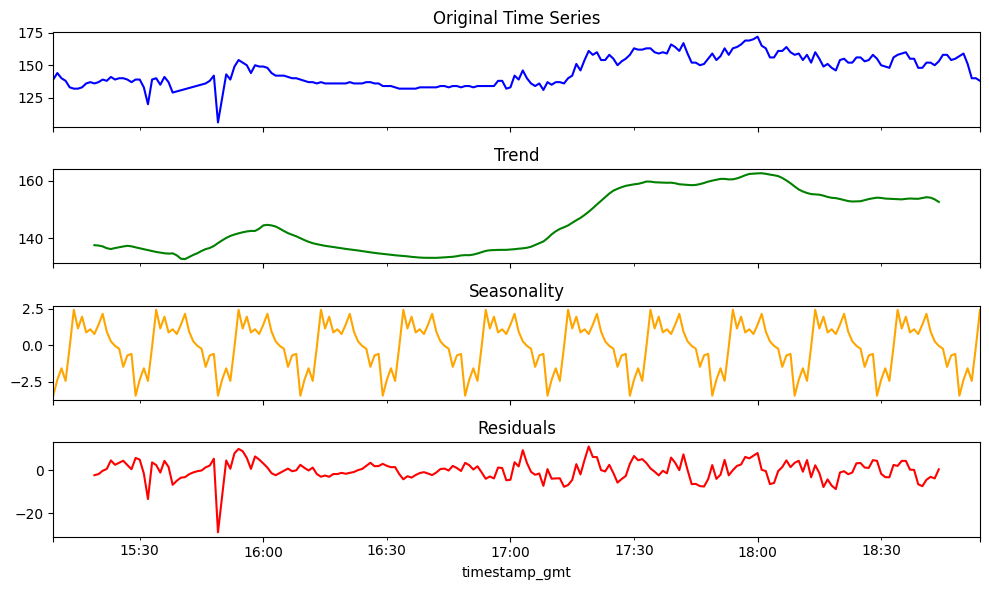

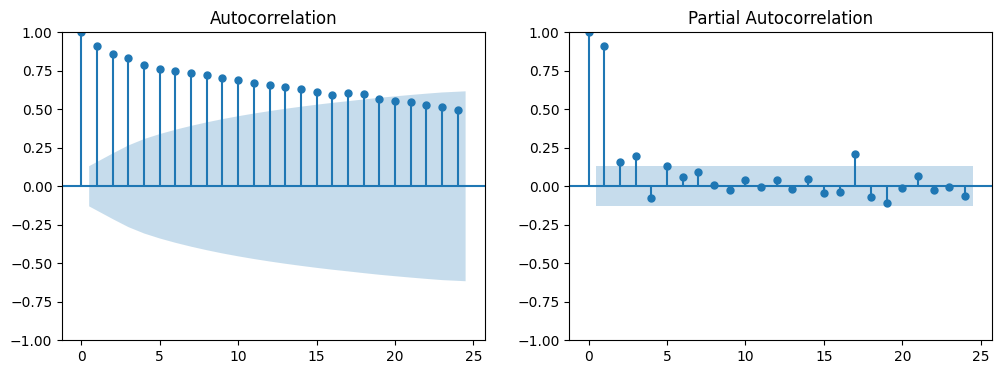

(-2.059379131280545, 0.2611588743274905)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# ADF Test for Stationarity
adf_result = adfuller(heart_rate_df["heart_rate"])  # Drop NaN to avoid issues
adf_statistic, p_value = adf_result[0], adf_result[1]

# Time Series Decomposition
decomposition = seasonal_decompose(heart_rate_df["heart_rate"].dropna(), model="additive", period=20)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

heart_rate_df["heart_rate"].plot(ax=axes[0], title="Original Time Series", color="blue")
decomposition.trend.plot(ax=axes[1], title="Trend", color="green")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality", color="orange")
decomposition.resid.plot(ax=axes[3], title="Residuals", color="red")

plt.tight_layout()
plt.show()

# Autocorrelation Plots (ACF & PACF)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(heart_rate_df["heart_rate"].dropna(), ax=axes[0])
plot_pacf(heart_rate_df["heart_rate"].dropna(), ax=axes[1])
plt.show()

# Display ADF Test results
adf_statistic, p_value


##**DATA PREPROCESSING**

In [ ]:
# convert Timestamp to int
heart_rate_df['minute'] = list(range(0, len(heart_rate_df.index)))

heart_rate_df.head()

,heart_rate,respiration_rate,oximeter,oximeter_pulse,log_heart_rate,minute
timestamp_gmt,,,,,,
2015-08-17 15:09:00,139.0,41.0,NaN,NaN,4.934474,0
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,4.969813,1
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,4.941642,2
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,4.927254,3
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,4.890349,4


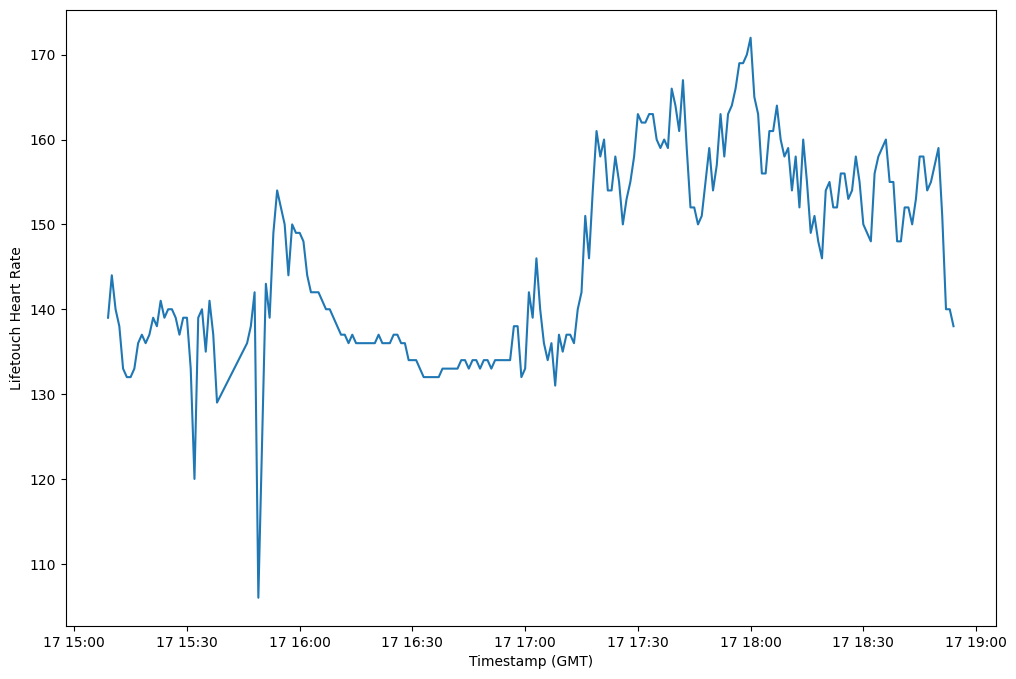

In [ ]:
# plot time series
#Because it has been set to an index, the word Timestamp (GMT) would not be used, instead heart_rate_df.index
plt.figure(figsize=(12, 8))
plt.plot(heart_rate_df.index,heart_rate_df['heart_rate'])
plt.xlabel('Timestamp (GMT)')
plt.ylabel('Lifetouch Heart Rate')
plt.show()

Calculate the heart rate rolling mean and standard devviation

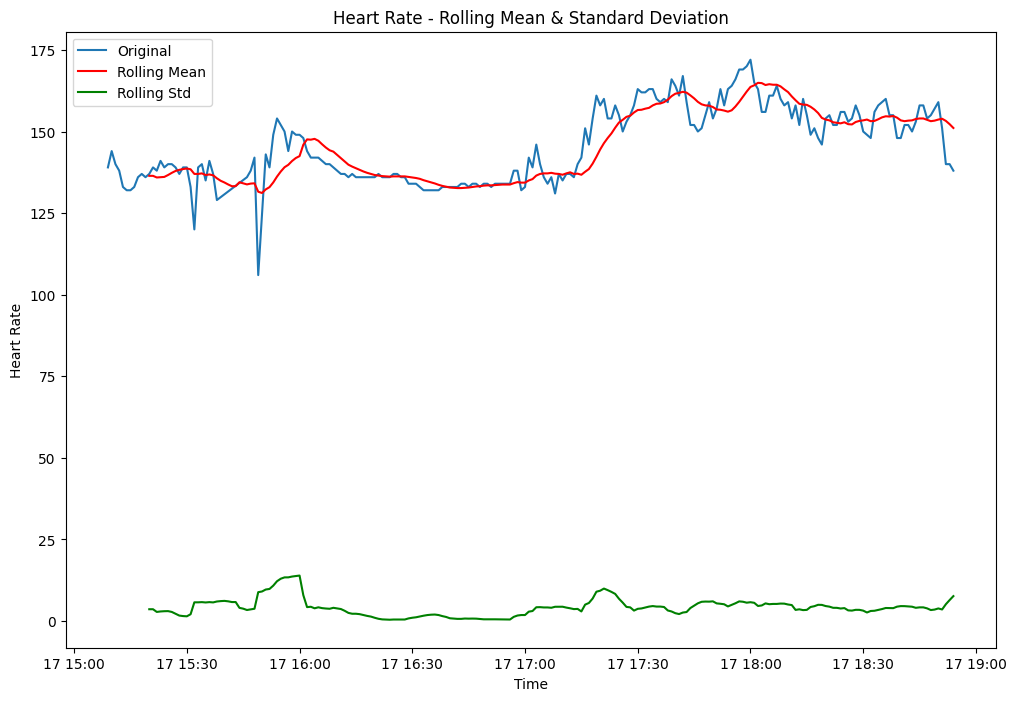

In [ ]:
# Calculate rolling mean and standard deviation
rolling_mean = heart_rate_df['heart_rate'].rolling(window=12).mean()
rolling_std = heart_rate_df['heart_rate'].rolling(window=12).std()

# Plot the original data, rolling mean, and rolling standard deviation
plt.figure(figsize=(12,8))
plt.plot(heart_rate_df.index, heart_rate_df['heart_rate'], label='Original')
plt.plot(heart_rate_df.index, rolling_mean, label='Rolling Mean', color='red')
plt.plot(heart_rate_df.index, rolling_std, label='Rolling Std', color='green')
plt.title('Heart Rate - Rolling Mean & Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

**By looking at the plot above, I can conclude that, it is non-stationary because mean and variance is not constant.**

KPSS Test For Stationarity

In [ ]:
import statsmodels.api as sm
# check stationarity of the series
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value} ')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [ ]:
check_stationarity(heart_rate_df["heart_rate"])

p value: 0.01 
Result: The series is not stationary 



Log Transformation

In [ ]:
# add new column 'log_heart_rate' with log transformed values
heart_rate_df['log_heart_rate'] = np.log(heart_rate_df['heart_rate'])

print(heart_rate_df.shape)
heart_rate_df.head()

(226, 5)


,heart_rate,respiration_rate,oximeter,oximeter_pulse,log_heart_rate
timestamp_gmt,,,,,
2015-08-17 15:09:00,139.0,41.0,NaN,NaN,4.934474
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,4.969813
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,4.941642
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,4.927254
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,4.890349


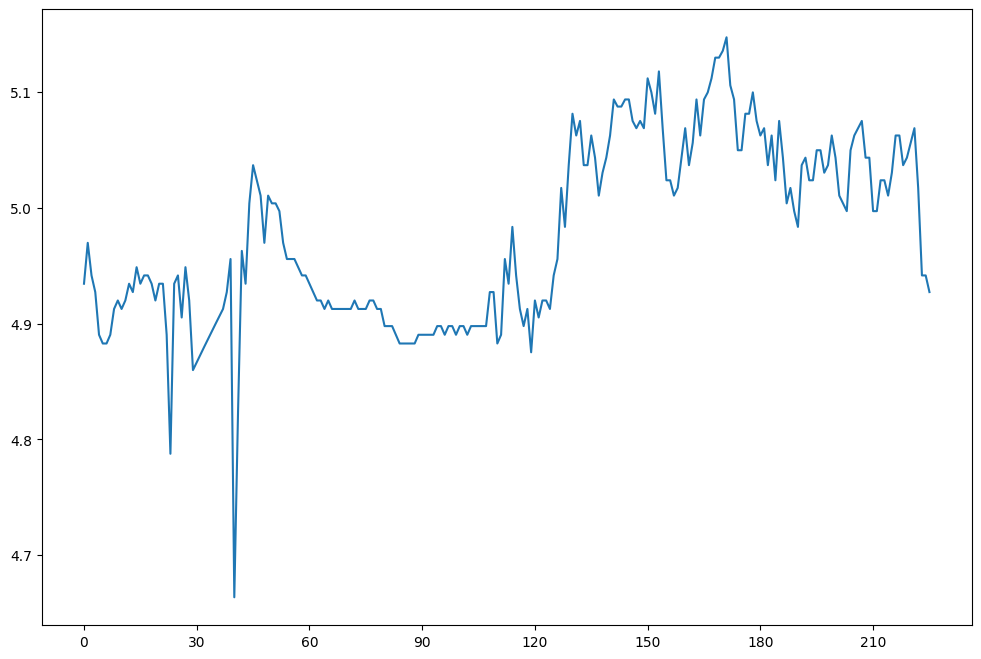

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(heart_rate_df['minute'],heart_rate_df['log_heart_rate'])
plt.xticks(np.arange(min(heart_rate_df['minute']), max(heart_rate_df['minute'])+1, 30)) # define x-axis step size
plt.show()

Deseasonalisation

In [ ]:
heart_rate_df['deseasonalised_heart_rate'] = heart_rate_df[['log_heart_rate']].diff(axis=0, periods=12)
heart_rate_df.head(15)

,heart_rate,respiration_rate,oximeter,oximeter_pulse,log_heart_rate,minute,deseasonalised_heart_rate
timestamp_gmt,,,,,,,
2015-08-17 15:09:00,139.0,41.0,NaN,NaN,4.934474,0,NaN
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,4.969813,1,NaN
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,4.941642,2,NaN
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,4.927254,3,NaN
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,4.890349,4,NaN
2015-08-17 15:14:00,132.0,41.0,92.0,134.0,4.882802,5,NaN
2015-08-17 15:15:00,132.0,47.0,92.0,135.0,4.882802,6,NaN
2015-08-17 15:16:00,133.0,44.0,92.0,135.0,4.890349,7,NaN
2015-08-17 15:17:00,136.0,45.0,94.0,136.0,4.912655,8,NaN


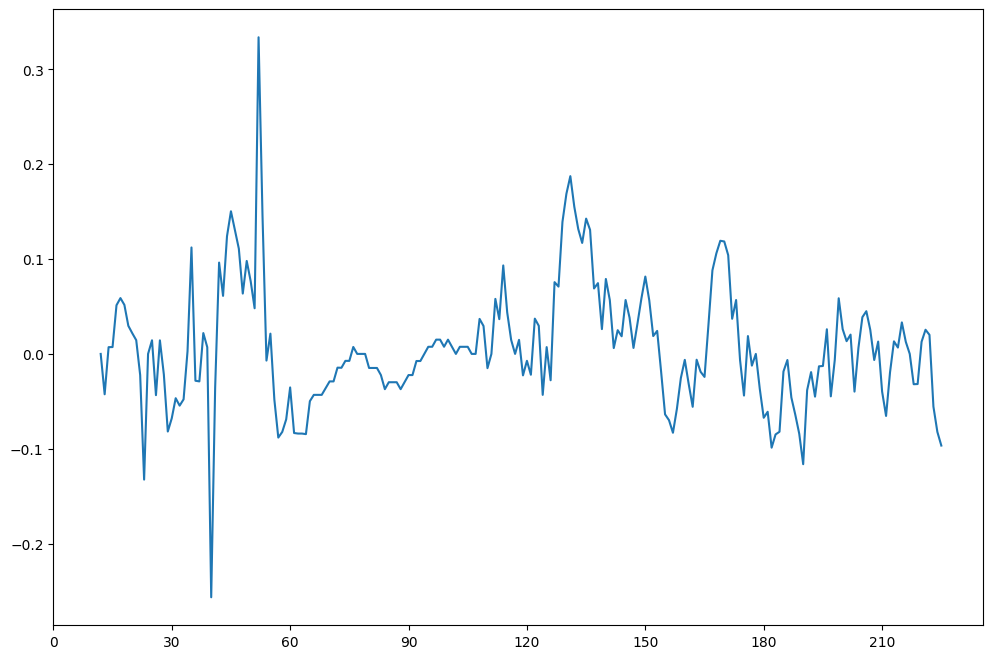

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(heart_rate_df['minute'],heart_rate_df['deseasonalised_heart_rate'])
plt.xticks(np.arange(min(heart_rate_df['minute']), max(heart_rate_df['minute'])+1, 30)) # define x-axis step size
plt.show()

In [ ]:
heart_rate_df['differenced_heart_rate'] = heart_rate_df[['deseasonalised_heart_rate']].diff(axis=0, periods=1)
heart_rate_df.head(15)

,heart_rate,respiration_rate,oximeter,oximeter_pulse,log_heart_rate,minute,deseasonalised_heart_rate,differenced_heart_rate
timestamp_gmt,,,,,,,,
2015-08-17 15:09:00,139.0,41.0,NaN,NaN,4.934474,0,NaN,NaN
2015-08-17 15:10:00,144.0,40.0,92.0,140.0,4.969813,1,NaN,NaN
2015-08-17 15:11:00,140.0,42.0,89.0,144.0,4.941642,2,NaN,NaN
2015-08-17 15:12:00,138.0,45.0,93.0,141.0,4.927254,3,NaN,NaN
2015-08-17 15:13:00,133.0,42.0,94.0,134.0,4.890349,4,NaN,NaN
2015-08-17 15:14:00,132.0,41.0,92.0,134.0,4.882802,5,NaN,NaN
2015-08-17 15:15:00,132.0,47.0,92.0,135.0,4.882802,6,NaN,NaN
2015-08-17 15:16:00,133.0,44.0,92.0,135.0,4.890349,7,NaN,NaN
2015-08-17 15:17:00,136.0,45.0,94.0,136.0,4.912655,8,NaN,NaN


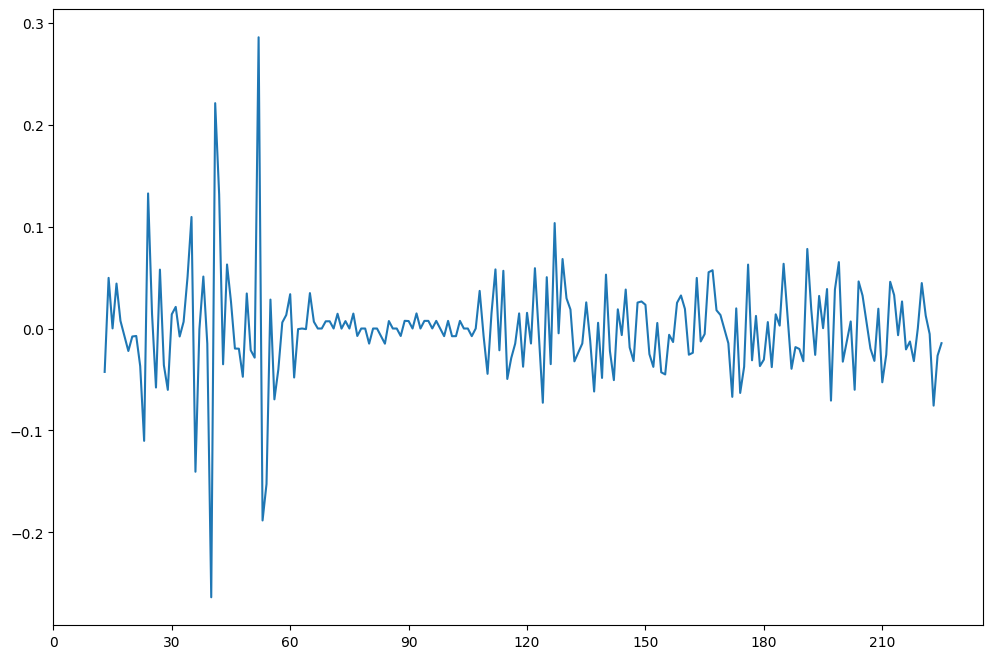

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(heart_rate_df['minute'],heart_rate_df['differenced_heart_rate'])
plt.xticks(np.arange(min(heart_rate_df['minute']), max(heart_rate_df['minute'])+1, 30))  # define x-axis step size
plt.show()

Let's check the rolling mean again

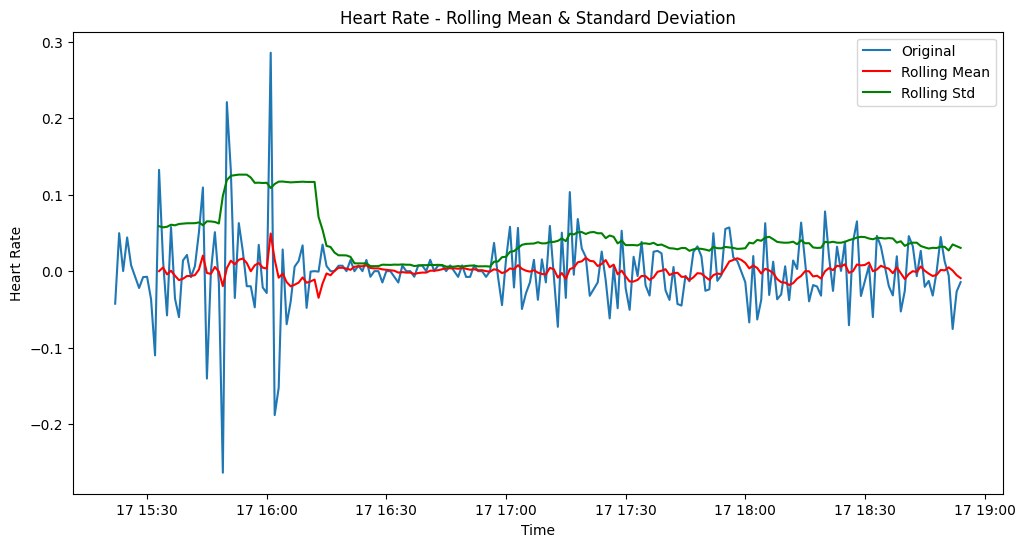

In [ ]:
# Calculate rolling mean and standard deviation
rolling_mean = heart_rate_df['differenced_heart_rate'].rolling(window=12).mean()
rolling_std = heart_rate_df['differenced_heart_rate'].rolling(window=12).std()

# Plot the original data, rolling mean, and rolling standard deviation
plt.figure(figsize=(12,6))
plt.plot(heart_rate_df.index, heart_rate_df['differenced_heart_rate'], label='Original')
plt.plot(heart_rate_df.index, rolling_mean, label='Rolling Mean', color='red')
plt.plot(heart_rate_df.index, rolling_std, label='Rolling Std', color='green')
plt.title('Heart Rate - Rolling Mean & Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

In [ ]:
check_stationarity(heart_rate_df['differenced_heart_rate'][13:])

p value: 0.1 
Result: The series is stationary 



##**MODELLING**

##**SARIMAX(P,D,Q,s)**

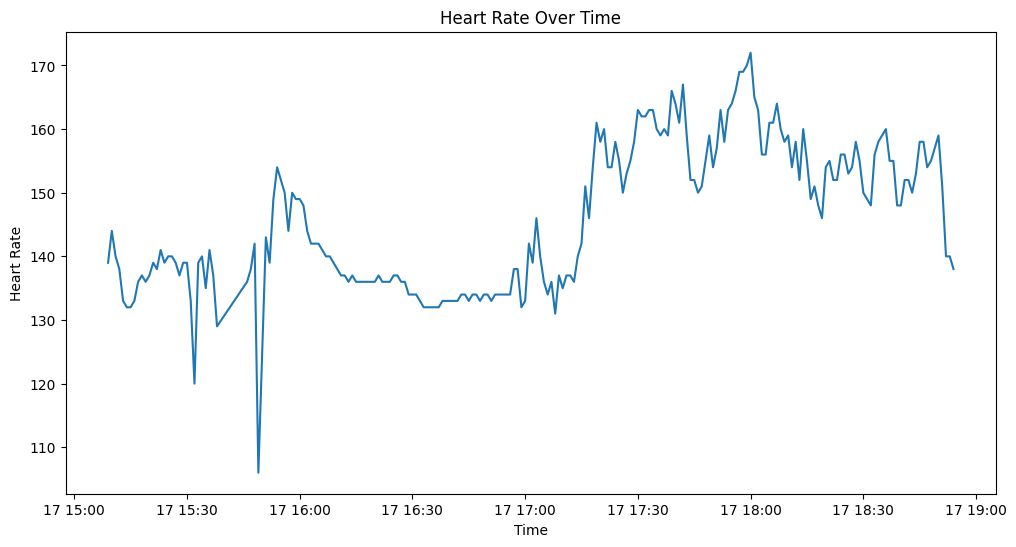

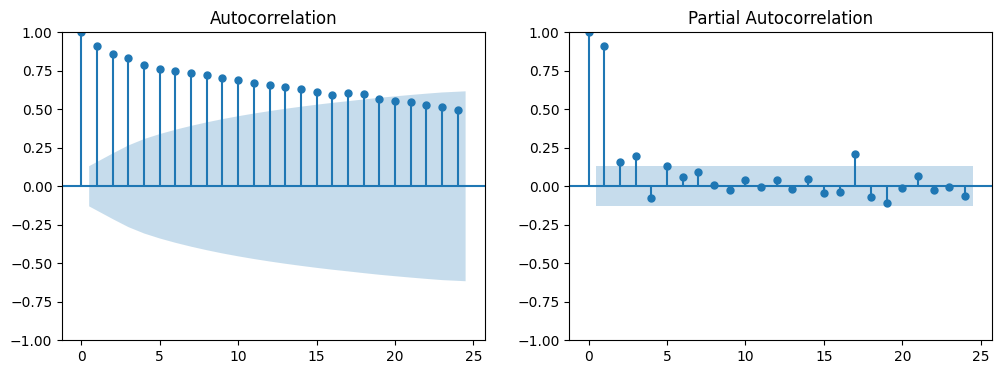

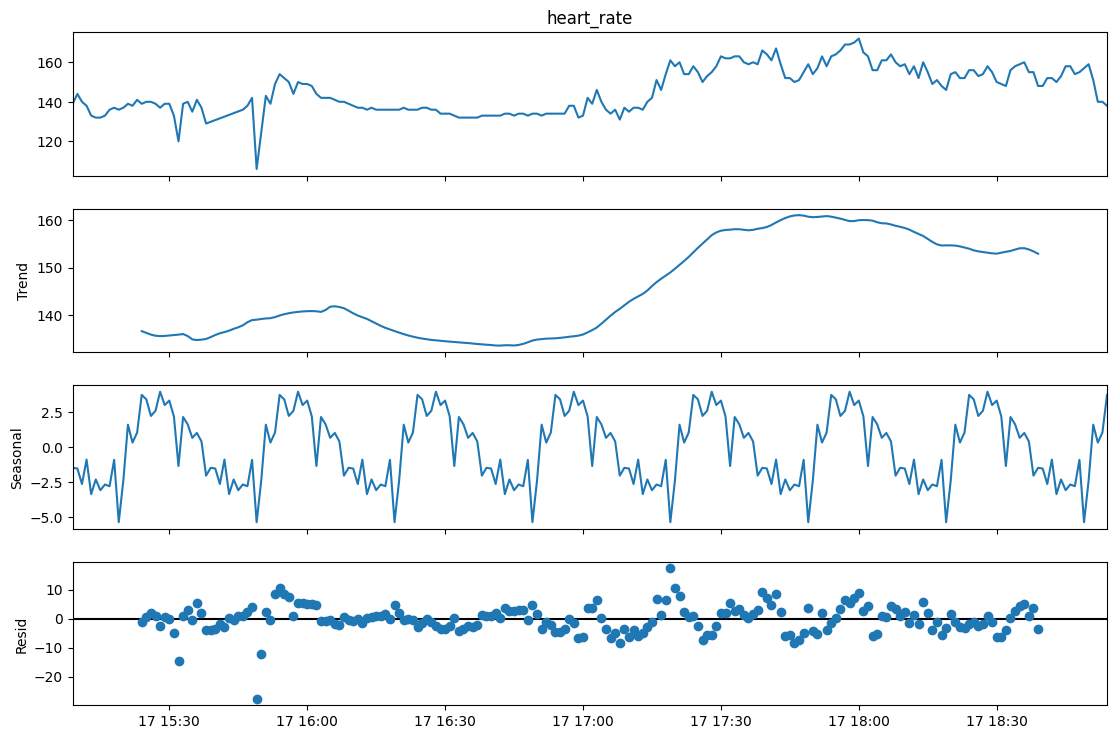

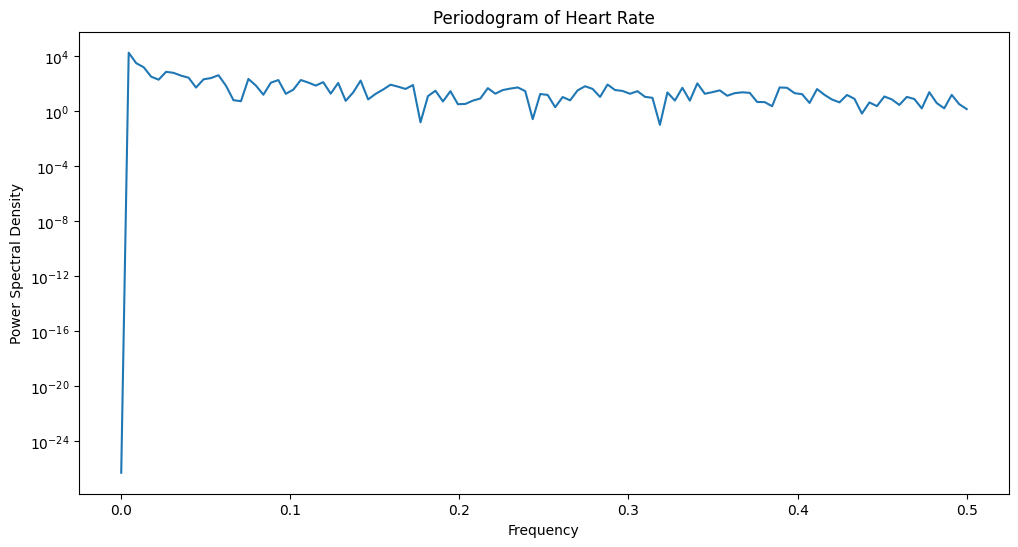

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(heart_rate_df['heart_rate'])
plt.title('Heart Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.show()

# ACF and PACF:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(heart_rate_df['heart_rate'].dropna(), ax=axes[0])
plot_pacf(heart_rate_df['heart_rate'].dropna(), ax=axes[1])
plt.show()

# Seasonal Decomposition:
decomposition = seasonal_decompose(heart_rate_df['heart_rate'].dropna(), model='additive', period=30)  # Experiment with different periods
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# Spectral Analysis (Periodogram):
from scipy import signal
f, Pxx_den = signal.periodogram(heart_rate_df['heart_rate'].dropna())
plt.figure(figsize=(12, 6))
plt.semilogy(f, Pxx_den)
plt.title('Periodogram of Heart Rate')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.show()

Check Correlation between heart rate and other features

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
# 1. Calculate correlation matrix
correlation_matrix = heart_rate_df.corr()

# 2. Get correlation with target variable
target_correlation = correlation_matrix['heart_rate']

# 3. Display correlation values
print(target_correlation)

heart_rate                   1.000000
respiration_rate             0.814110
oximeter                    -0.419132
oximeter_pulse              -0.311523
log_heart_rate               0.998800
minute                       0.676449
deseasonalised_heart_rate    0.396665
differenced_heart_rate       0.127189
Name: heart_rate, dtype: float64


From the correlation, I can see Respiration Rate is highly correlated to Heart Rate.



Therefore, I will use as the exog variable in my SARIMAX model.

In [ ]:
p = d = q = range(0, 4)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(1, 0, 3, 60)]

for param in pdq:
    for param_seasonal in seasonal_pdq:
          mod = sm.tsa.statespace.SARIMAX(heart_rate_df['heart_rate'],
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

          mod_fit = mod.fit()

          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_fit.aic))

ARIMA(0, 0, 0)x(1, 0, 3, 60)12 - AIC:353.6024572931268
ARIMA(0, 0, 1)x(1, 0, 3, 60)12 - AIC:309.0860153979673
ARIMA(0, 0, 2)x(1, 0, 3, 60)12 - AIC:302.89625429294074
ARIMA(0, 0, 3)x(1, 0, 3, 60)12 - AIC:285.4922971180228
ARIMA(0, 1, 0)x(1, 0, 3, 60)12 - AIC:256.81870025456624
ARIMA(0, 1, 1)x(1, 0, 3, 60)12 - AIC:252.77457404200533
ARIMA(0, 1, 2)x(1, 0, 3, 60)12 - AIC:245.7838381950273
ARIMA(0, 1, 3)x(1, 0, 3, 60)12 - AIC:238.1252837468301
ARIMA(0, 2, 0)x(1, 0, 3, 60)12 - AIC:283.6541152192838
ARIMA(0, 2, 1)x(1, 0, 3, 60)12 - AIC:249.9085740732864
ARIMA(0, 2, 2)x(1, 0, 3, 60)12 - AIC:245.69414104135618
ARIMA(0, 2, 3)x(1, 0, 3, 60)12 - AIC:233.49667629640726
ARIMA(0, 3, 0)x(1, 0, 3, 60)12 - AIC:321.1001395537996
ARIMA(0, 3, 1)x(1, 0, 3, 60)12 - AIC:272.27656313661714
ARIMA(0, 3, 2)x(1, 0, 3, 60)12 - AIC:239.89261438545222
ARIMA(0, 3, 3)x(1, 0, 3, 60)12 - AIC:229.20852974992346
ARIMA(1, 0, 0)x(1, 0, 3, 60)12 - AIC:263.18057352777475
ARIMA(1, 0, 1)x(1, 0, 3, 60)12 - AIC:260.29002309349653


In [ ]:
heart_rate_df = heart_rate_df.asfreq('min')
# specify model
sarimax_model = sm.tsa.statespace.SARIMAX(heart_rate_df['heart_rate'],
                                  order=(1, 1, 3),
                                  seasonal_order=(1, 0, 3, 60),
                                  exog=heart_rate_df[['respiration_rate']],  # Exogenous variable
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train the sarimax model
sarimax_model_fit = sarimax_model.fit()
# Print model summary
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         heart_rate   No. Observations:                  226
Model:             SARIMAX(1, 1, 3)x(1, 0, 3, 60)   Log Likelihood                -105.426
Date:                            Fri, 28 Feb 2025   AIC                            230.852
Time:                                    13:52:57   BIC                            247.988
Sample:                                08-17-2015   HQIC                           237.092
                                     - 08-17-2015                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
respiration_rate    -0.1061      0.117     -0.904      0.366      -0.336       0.124
ar.L1            

##**RESULT AND EVALUATION**

In [ ]:
# predict
sarimax_predict = sarimax_model_fit.predict(start=pd.to_datetime('2015-08-17 17:45:00'), end=pd.to_datetime('2015-08-17 18:54:00'))

In [ ]:

# calculate MSE
# actuals = heart_rate_df.loc['2015-08-17 15:12:00':, 'heart_rate']
actuals = heart_rate_df['heart_rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00']
print(f'Mean Squared Error: {round(mean_squared_error(actuals, sarimax_predict), 2)}')

# calculate the RMSE
actuals = heart_rate_df['heart_rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00' ]
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, sarimax_predict)), 2)}')

# calculate the MAE
actuals = heart_rate_df['heart_rate']
actuals = actuals.loc['2015-08-17 17:45:00': '2015-08-17 18:54:00' ]
print(f'Mean Absolute Error: {round(mean_absolute_error(actuals, sarimax_predict), 2)}')

Mean Squared Error: 11.35
Root Mean Squared Error: 3.37
Mean Absolute Error: 2.72


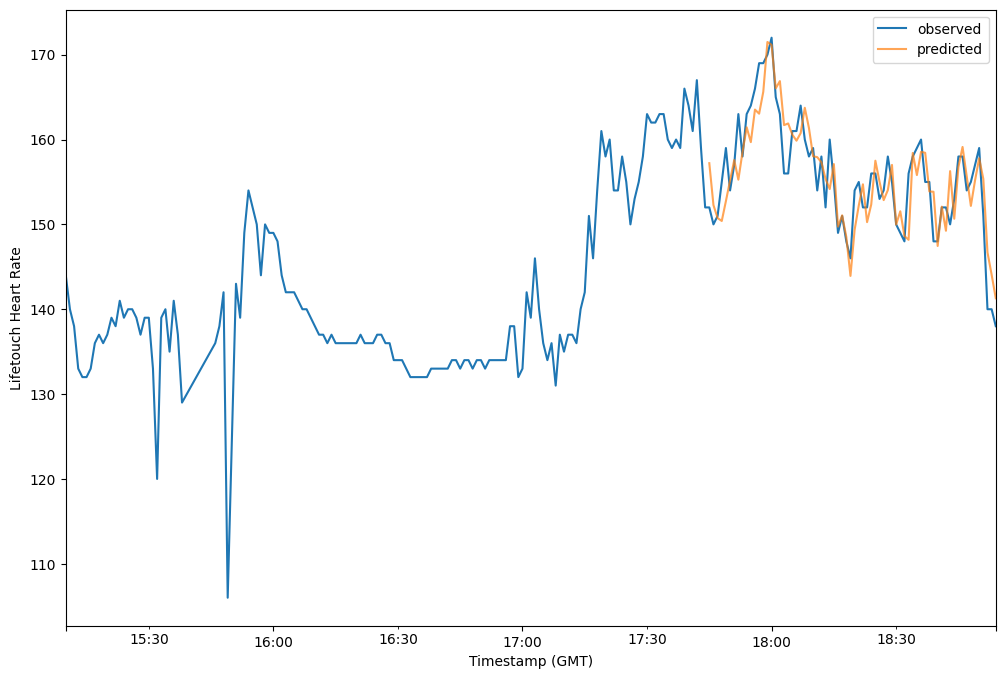

In [ ]:
# plot observations and predictions
ax = heart_rate_df['2015-08-17 15:10:00':]['heart_rate'].plot(label='observed', figsize=(12, 8))
sarimax_predict.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
# future forecasts
# Assuming heart_rate_df has the exogenous variable 'respiration_rate'
future_exog = heart_rate_df[['respiration_rate']].iloc[-20:].values  # Get last 20 values of respiration_rate

# Provide future exogenous values to forecast
sarimax_forecasts = sarimax_model_fit.forecast(steps=20, exog=future_exog)
print(sarimax_forecasts)

2015-08-17 18:55:00    140.597441
2015-08-17 18:56:00    140.399571
2015-08-17 18:57:00    139.457731
2015-08-17 18:58:00    139.382701
2015-08-17 18:59:00    138.666727
2015-08-17 19:00:00    138.367467
2015-08-17 19:01:00    140.953800
2015-08-17 19:02:00    141.574636
2015-08-17 19:03:00    144.963200
2015-08-17 19:04:00    145.371932
2015-08-17 19:05:00    143.150914
2015-08-17 19:06:00    143.482168
2015-08-17 19:07:00    142.091682
2015-08-17 19:08:00    143.405850
2015-08-17 19:09:00    144.590984
2015-08-17 19:10:00    143.990129
2015-08-17 19:11:00    144.968055
2015-08-17 19:12:00    143.415359
2015-08-17 19:13:00    146.747686
2015-08-17 19:14:00    143.749124
Freq: min, Name: predicted_mean, dtype: float64


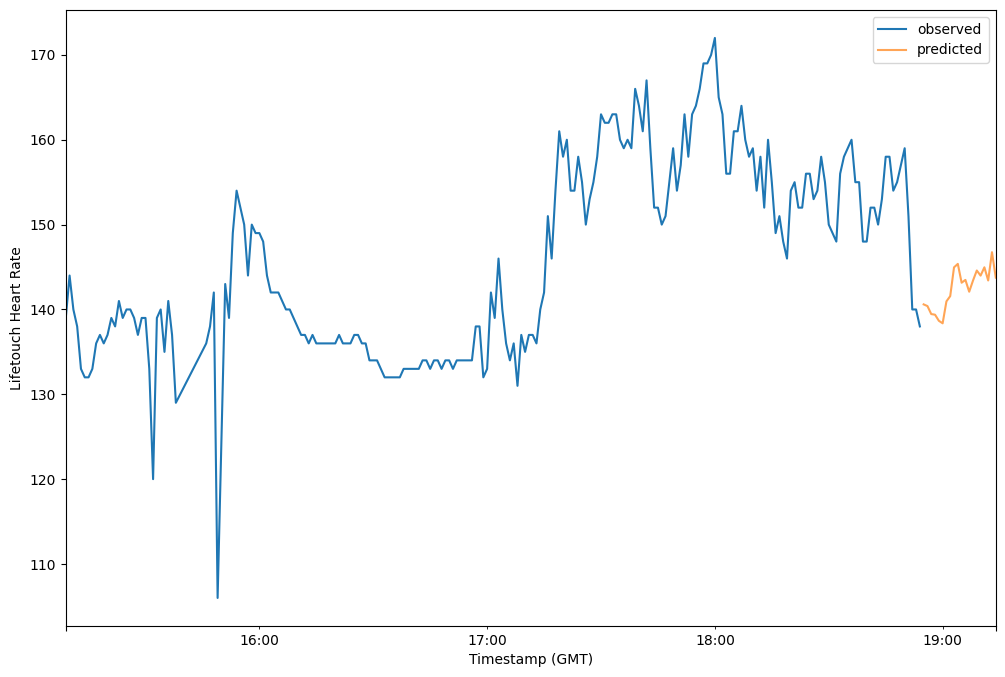

In [ ]:
# plot observations and predictions
ax = heart_rate_df['heart_rate'].plot(label='observed', figsize=(12, 8))
sarimax_forecasts.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
# Create DataFrame with index 1-20 and forecasted values rounded to 2 decimal places
forecast_df = pd.DataFrame({
    'index': range(1, 21),
    'label': [round(f, 2) for f in sarimax_forecasts]
}).set_index('index')

# Save to CSV
forecast_df.to_csv('heart_rate_forecast.csv')

# Display the DataFrame (for verification)
print(forecast_df)

        label
index        
1      140.60
2      140.40
3      139.46
4      139.38
5      138.67
6      138.37
7      140.95
8      141.57
9      144.96
10     145.37
11     143.15
12     143.48
13     142.09
14     143.41
15     144.59
16     143.99
17     144.97
18     143.42
19     146.75
20     143.75
